<a href="https://colab.research.google.com/github/Umercia/wind_power/blob/master/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical learning for wind power

# Models


In [2]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# mount drive from MyGoogleDrive
from google.colab import drive  
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1.0 Import Data

In [3]:
# importing

file_path = "/content/gdrive/My Drive/Colab Notebooks/wind_power/data/2.model_inputs/model_input.csv"

data = pd.read_csv(file_path,
                 index_col=[0],
                 header=[0],
                 parse_dates=True)

data.head(3)

,ws_avg-WT11,ws_avg-WT12,ws_avg-WT13,ws_avg-WT14,ws_avg-WT21,ws_avg-WT22,ws_avg-WT23,ws_avg-WT24,ws_avg-WF,pwr_avg-WT11,...,sect-NE.E,sect-E,sect-E.SE,sect-SE.S,sect-S,sect-S.SW,sect-SW.W,sect-W,sect-W.NW,sect-NW.N
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.3,9.6,9.6,9.9,9.7,9.6,9.8,10.1,9.7000,1375.0,...,0,0,0,0,0,1,0,0,0,0
2014-01-01 00:10:00,9.7,9.9,9.8,10.1,10.1,9.8,10.2,10.3,9.9875,1537.0,...,0,0,0,0,0,1,0,0,0,0
2014-01-01 00:20:00,9.6,9.8,9.8,9.9,10.0,9.7,10.2,10.2,9.9000,1492.0,...,0,0,0,0,0,1,0,0,0,0


In [0]:
# Hysteresis Zone

mask = data.loc[:,"ws_avg-WF"] > 21  
data.loc[mask,"pwr_avg-WF"] = np.NaN

In [0]:
# usefull functions

# reference model using power curve and wind
from sklearn.metrics import mean_squared_error

def pc_model(X_wind_speed, power_curve):
    """
    model that use a power curve to deduct power output
    Inputs:
        - wind_speed: array of wind speed
        - power_curve: dictionary {wind_speed : power}
   Output
        - y_pred: prediction array
    """
    round_ws = np.round(X_wind_speed,0).flatten()
    round_ws = round_ws.astype(int)
    
    y_pred = np.full(len(round_ws), 0)
    for ws, pwr in power_curve.items():
        mask = round_ws == ws
        y_pred[mask] = pwr
        
    return y_pred


def RMSE(y_true, y_pred, percent=False, nominal_pwr=3000):
    """ Compute Root mean Square Error of two series
    It also filter the NaN value"""
    
    mask = np.isnan(y_true) | np.isnan(y_pred)
    y_true_filt = y_true[~mask]
    y_pred_filt = y_pred[~mask]
    
    rmse = mean_squared_error(y_true_filt, y_pred_filt)**0.5
    
    if percent == False:
        return rmse
    else:
        rmse_perc = rmse/nominal_pwr
        return rmse_perc

    
def filter_nan(X, y):
    """ Compute Root mean Square Error of two series
    It also filter the NaN value"""
    
#     if type(X) is pd.core.series.Series:  # if X is 1D
#         X = pd.DataFrame(X)
    
    len_X = len(X)
    
    if len(X.shape) == 1:
        mask = np.isnan(X) | np.isnan(y)
    else:
        mask = np.isnan(X).any(axis=1) | np.isnan(y)
    
    
    X_filt = X[~mask]
    y_filt = y[~mask]
    leng_X_filt = len(X_filt)
    n_point_filt = len_X-leng_X_filt
    
    print("{}({:.2%}) rows have been filtered for NaN values ".format(n_point_filt,
                                                     float(n_point_filt)/len_X))
    
    return X_filt, y_filt


def plot_pc_train_test(xtrain, ytrain, xtest, ytest, ypred, title):
    
    plt.figure(figsize=(21, 6))
    plt.suptitle(title,fontsize=25, fontweight="bold")
    
    # power curve plot of the train set ----------------------------------------
    plt.subplot(1,3,1)
    plt.title("train set", 
              size=16, fontweight="bold")
    plt.scatter(x=xtrain[:,0],
                    y=ytrain,
                    alpha=0.1,
                    s=5,
                    label="measurement")
    plt.scatter(x=xtest[:,0],
                    y=ypred,
                    alpha=0.3,
                    s=5,
                    c="orange",
                    label="prediction")
    plt.xlabel("wind speed [m/s]")
    plt.ylabel("power [kW]")
    plt.legend()
    
    # power curve plot of the test set -----------------------------------------
    plt.subplot(1,3,2)
    rmse_test = RMSE(ytest, ypred, percent=True)
    plt.title("test data - RMSE={:.2%}".format(rmse_test),
              size=16, fontweight="bold")
    plt.scatter(x=xtest[:,0],
                    y=ytest,
                    alpha=0.1,
                    s=5,
                    label="measurement")
    plt.scatter(x=xtest[:,0],
                    y=ypred,
                    alpha=0.3,
                    s=5,
                    c="orange",
                    label="prediction")
    plt.xlabel("wind speed [m/s]")
    plt.ylabel("power [kW]")
    plt.legend()
    
    # y_pred veruse y_real plot ------------------------------------------------
    plt.subplot(1,3,3)
    r2 = np.corrcoef(ypred, ytest)[0,1]**2
    plt.title("y_real vesus y_pred - R2 = {:.1%}".format(r2), 
              size=16, fontweight="bold")
    plt.scatter(x=ytest,
                y=ypred,
                alpha=0.1,
                c="purple",
                s=5)
    plt.xlabel("y_real")
    plt.ylabel("y_pred")
    
    plt.show()    

In [125]:


selected_wtg = "WT13"

# simple mode just by using wind speed
X = data.loc[:,"ws_avg-" + selected_wtg]
X = pd.DataFrame(X)
y = data.loc[:,"pwr_avg-" + selected_wtg]

# Remove rows with NaN
X, y = filter_nan(X, y)


# split data
X_train = X[:end_train]
X_test = X[end_train:end_test]
y_train = y[:end_train]
y_test = y[end_train:end_test]

# convert to simple np.array  (multi-index heavy to handle without knowledge)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

22849(8.86%) rows have been filtered for NaN values 


In [0]:
# feature selection and split train/test 

selected_wtg = "WT13"
features = ["ws_avg-" + selected_wtg, "air_dens_avg-WF", "ti_avg-WF"]

se
# simple mode just by using wind speed
X = data.loc[:,features]
y = data.loc[:,"pwr_avg-" + selected_wtg]

end_train = "2015-12-31 23:50:00"
end_test = "2016-12-31 23:50:00"   # change in power curve occur during  2017: to investiguate

# Remove rows with NaN
X, y = filter_nan(X, y)

# split data
X_train = X[:end_train]
X_test = X[end_train:end_test]
y_train = y[:end_train]
y_test = y[end_train:end_test]

# convert to simple np.array  (multi-index heavy to handle without knowledge)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [0]:
# 2.0 models

 # 2.0 models

## 2.1 linear models

In this section we will run few simple models (power ~ wind speed). They will serve has baseline to compare with more advanced models.
1.   standard power curve provided by the manufactuer
2.   Sigmoid fit
3.   Linear regression with polynomial features




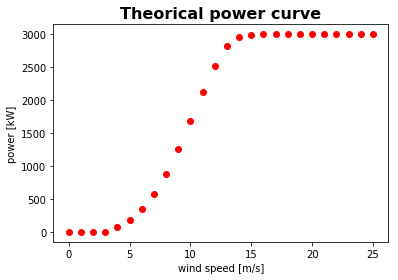

In [177]:
# read power curve

# dic format
file_path = "/content/gdrive/My Drive/Colab Notebooks/wind_power/data/Power Curve CDBO.csv"
power_curve = pd.read_csv(file_path, index_col=[0], sep=";")
power_curve = power_curve.to_dict()["Power"]

plt.title("Theorical power curve", size=16, fontweight="bold")
plt.scatter(x = power_curve.keys(),
           y = power_curve.values(),
           c = "r")
plt.xlabel("wind speed [m/s]")
plt.ylabel("power [kW]")
plt.show()

In [0]:
# for sigmoid fit
import scipy.optimize as opt   

# for Polynomial linear regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression


# 1. standard power curve provided by the manufactuer  -------------------------
def std_pc_model(X_wind_speed, power_curve):
    """
    model that use a power curve to deduct power output
    Inputs:
        - wind_speed: array of wind speed
        - power_curve: dictionary {wind_speed : power}
   Output
        - y_pred: prediction array
    """
    round_ws = np.round(X_wind_speed,0).flatten()
    round_ws = round_ws.astype(int)
    
    y_pred = np.full(len(round_ws), 0)
    for ws, pwr in power_curve.items():
        mask = round_ws == ws
        y_pred[mask] = pwr
        
    return y_pred

y_pred_pc = pc_model(X_test[:,0], power_curve)


# 2. Sigmoid fit  --------------------------------------------------------------
def draw_me_a_sigmoid(x, x0, k):  
    return 3000 * 1.0/(1.0+np.exp(-x0*(x-k)))


def sigmoid_fit(X_test, X_train, y_train):
    # subsample, heavy calculation time
    n_sample = 2000 
    sub_idx = np.random.choice(range(len(y_train)), n_sample, replace=False)
    X_train_sub = X_train[sub_idx, 0]
    y_train_sub = y_train[sub_idx]

    (b, c), _ = opt.curve_fit(draw_me_a_sigmoid, 
                            X_train_sub.flatten(), 
                            y_train_sub, 
                            p0=[0.59, 9.7])

    y_pred = draw_me_a_sigmoid(X_test[:,0].flatten(), b, c)
    return y_pred

y_pred_sig = sigmoid_fit(X_test, X_train, y_train)


# 3. Linear regression with polynomial features --------------------------------
linear_reg = Pipeline([('poly', PolynomialFeatures(degree=10)),
                ('linear', LinearRegression(fit_intercept=False,))])
linear_reg = linear_reg.fit(X_train[:,0].reshape((-1, 1)), y_train)
y_pred_lin = linear_reg.predict(X_test[:,0].reshape((-1, 1)))

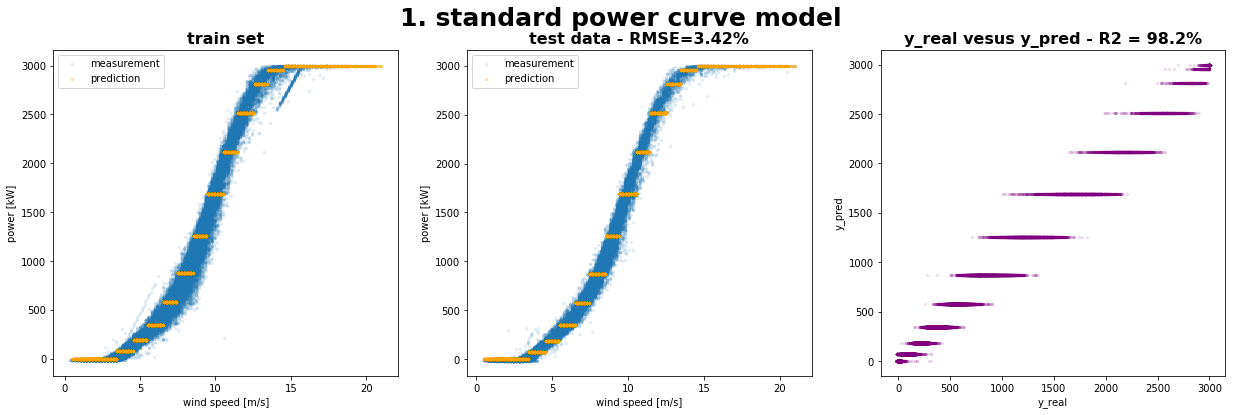

In [230]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_pc,"1. standard power curve model")

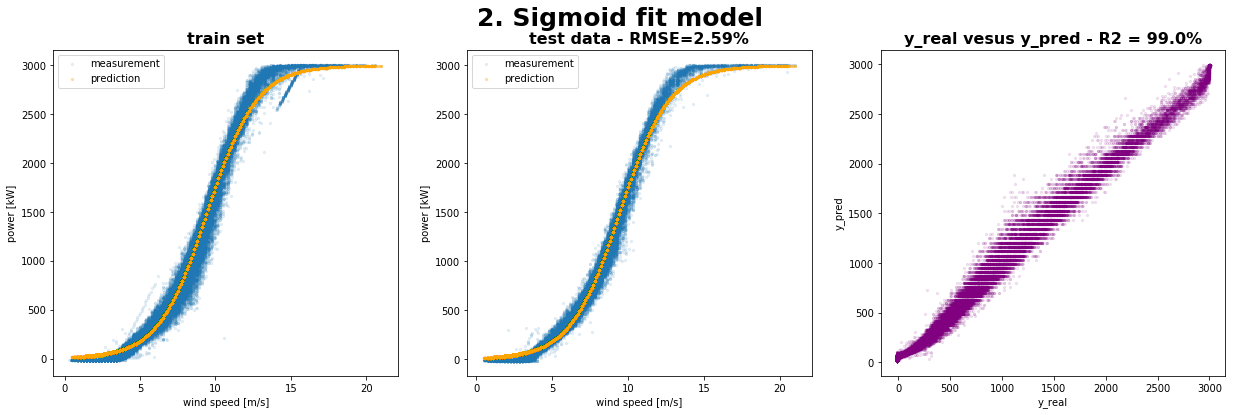

In [231]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_sig,"2. Sigmoid fit model")

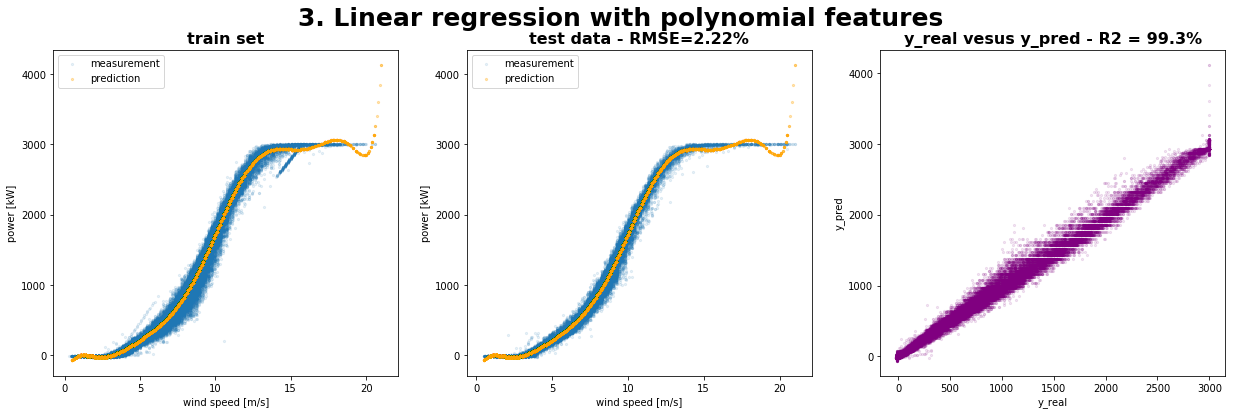

In [232]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_lin,"3. Linear regression with polynomial features")

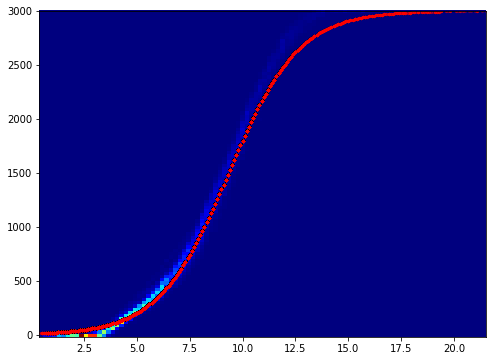

In [56]:
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
from scipy.stats import kde


plt.figure(figsize=(8, 6))
plt.hist2d(X_test.flatten(), y_test, bins=(100, 100), cmap=plt.cm.jet)
plt.scatter(x=X_test,
                y=y_pred_fit,
                alpha=0.3,
                s=5,
                c="red")

plt.show()


## 2.2 other models

1.   Random Forest
2.   Knn
3.   Bagged decision Trees
4.  XGBoost



In [0]:
# 1. Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

t0 = time()
param_grid = {'max_depth': [3, 4, 5, None],
              "min_samples_leaf": [1, 3, 5]
             }

rf_grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=6)
rf_grid.fit(X_train, y_train)
y_pred_rf_grid = rf_grid.predict(X_test)
print("rf done in: {} min".format(round((time() - t0)/60,0)))
t0 = time()

In [0]:
# 2. k-nearest neighbors
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.mean(axis=0)

# to give more weight to wind speed, we will mutiphy it by 10 (to grid search)
ws_weight = 30
X_train_scaled[:,0] = X_train_scaled[:,0]*ws_weight
X_test_scaled[:,0] = X_test_scaled[:,0]*ws_weight


t0 = time()
param_grid = {"n_neighbors": [5, 10, 15, 20],
              "weights": ["uniform", "distance"]
             }

knn_bagging_grid = GridSearchCV(neighbors.KNeighborsRegressor(n_jobs=-1), param_grid, cv=6)
knn_bagging_grid.fit(X_train, y_train)
y_pred_knn_grid = knn_bagging_grid.predict(X_test)
print("Knn optimized in: {} min".format(round((time() - t0)/60,0)))

In [0]:
# 3. Bagged decision Trees

from sklearn import model_selection
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeClassifier

n_sample = 10000
sub_idx = np.random.choice(range(len(y_train)), n_sample, replace=False)
X_train_sub = X_train[sub_idx]
y_train_sub = y_train[sub_idx]

t0 = time()
param_grid = {"bootstrap": [True, False],
              "bootstrap_features": [True, False]
             }

cart_bagging_grid = GridSearchCV(BaggingRegressor(n_estimators=20, n_jobs=-1), param_grid, cv=6)
cart_bagging_grid.fit(X_train, y_train)
y_pred_cart_grid = cart_bagging_grid.predict(X_test)
print("Bagged decision Trees done in: {} min".format(round((time() - t0)/60,0)))

In [0]:
# 4. XGBoost
import xgboost as xgb

# A parameter grid for XGBoost
t0 = time()

# XGBoost
param_grid = {'max_depth': [1,2, 3, 5],
             }


# param_grid = {'max_depth': [3, 4, 5],
#                 'min_child_weight': [1, 5, 10],
#                 'gamma': [0.5, 1, 1.5, 2, 5],
#                 'subsample': [0.6, 0.8, 1.0],
#                 'colsample_bytree': [0.6, 0.8, 1.0]
#              }
xgb_grid = GridSearchCV(xgb.XGBRegressor(n_jobs=-1), param_grid, cv=6)
xgb_grid.fit(X_train, y_train)
y_pred_xgb_grid = xgb_grid.predict(X_test)


print("XGB done in: ", round((time() - t0)/60,0), " min")

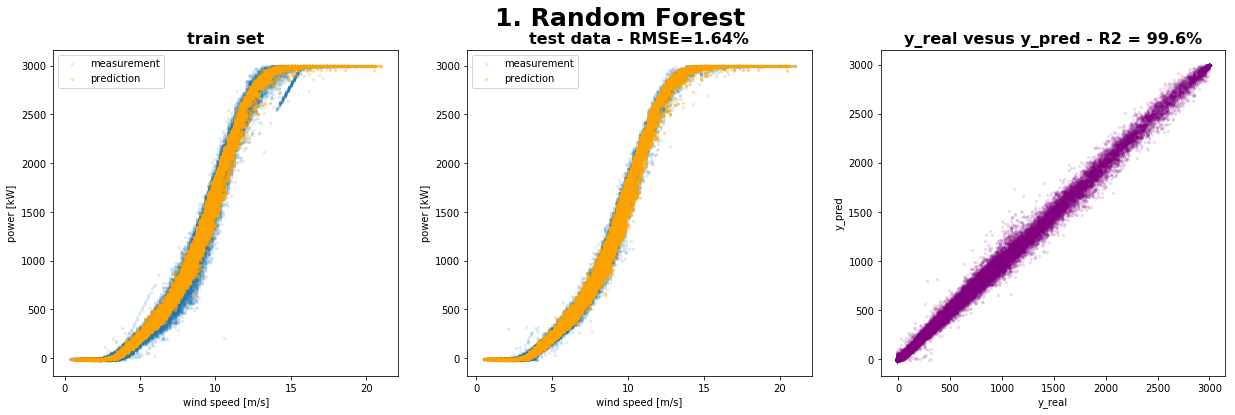

In [233]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_rf_grid, "1. Random Forest")

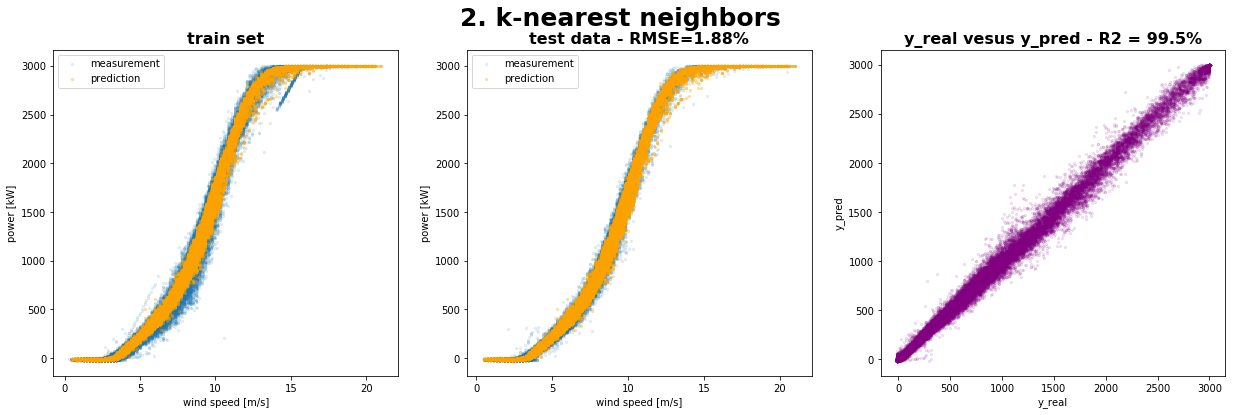

In [234]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_knn_grid, "2. k-nearest neighbors")

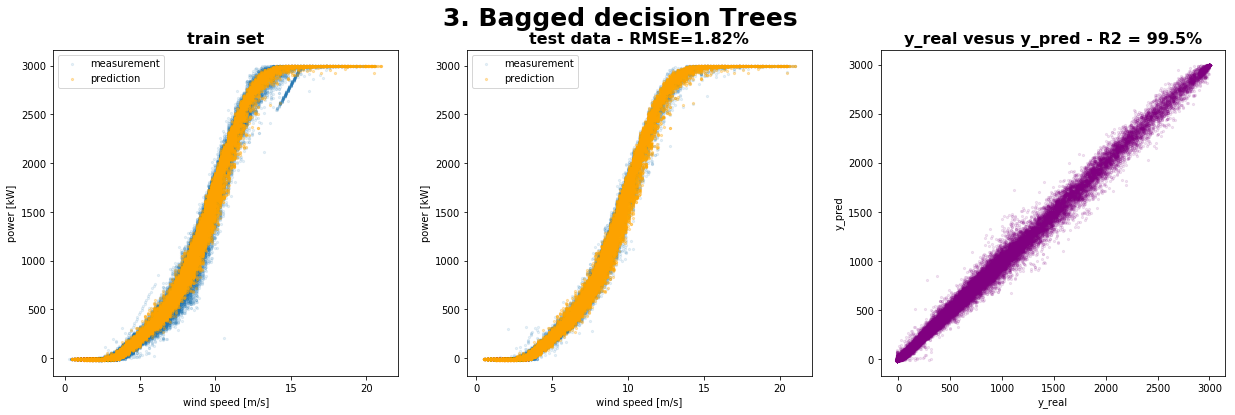

In [235]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_cart_grid, "3. Bagged decision Trees")

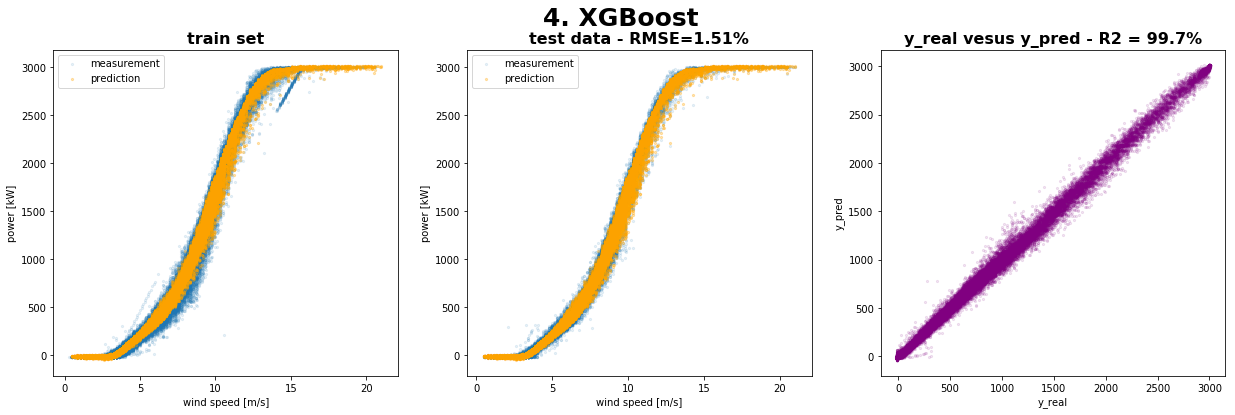

In [236]:
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_xgb_grid, "4. XGBoost")

In [249]:
residuals = pd.DataFrame({"power_curve": y_test - y_pred_pc,
                            "sigmoid": y_test - y_pred_sig,
                            "poly": y_test - y_pred_lin,
                            "Random Forest": y_test - y_pred_rf_grid,
                            "Knn": y_test - y_pred_knn_grid,
                            "CART+Bagging": y_test - y_pred_cart_grid,
                            "XGBoost": y_test - y_pred_xgb_grid     
                          })


residuals = residuals.melt()
residuals.sample(3)

,variable,value
206061,poly,99.444088
154884,XGBoost,5.519226
106216,Random Forest,34.603306


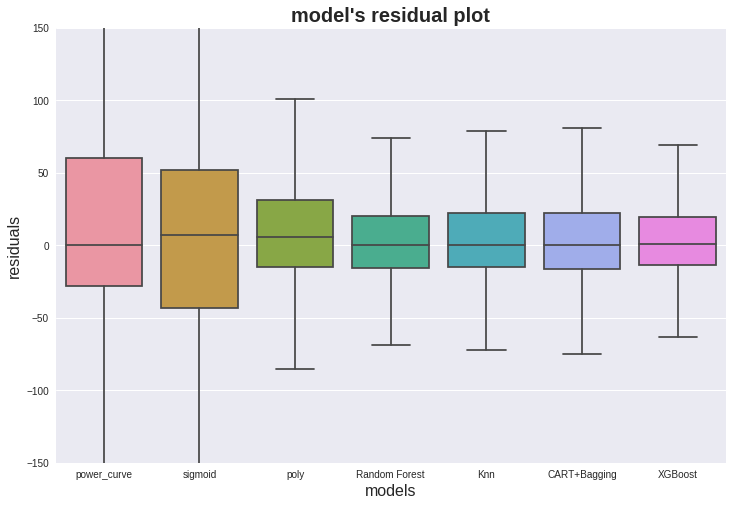

In [265]:
import seaborn as sns

plt.figure(figsize=(12,8))
plt.title("Model's residual plot", size=20, fontweight="bold" )
sns.boxplot(x="variable", y="value", data=residuals, order=["power_curve","sigmoid",
                            "poly","Random Forest","Knn", "CART+Bagging", "XGBoost"],
           whis=1.5, fliersize=0)
plt.ylim(-150, 150)
plt.ylabel("residuals [kW]", size=16)
plt.xlabel("models", size=16)
plt.show()

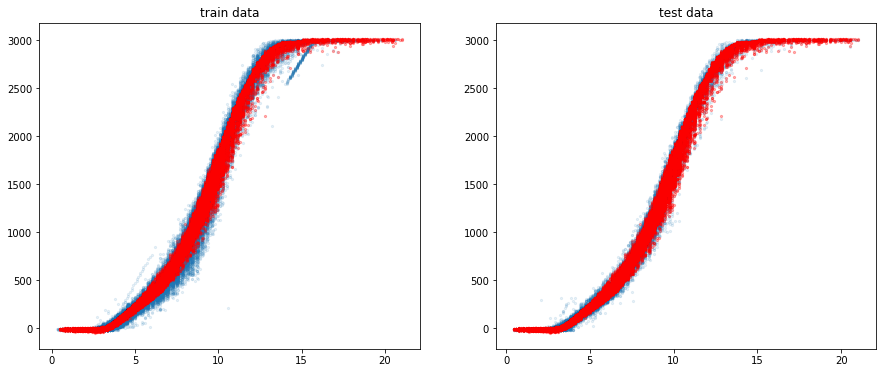

RMSE = 45.2 kW (1.51%)


In [130]:
# XGB
import xgboost as xgb
xgb_reg = xgb.XGBRegressor(max_depth=5)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)


# plot 
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_xgb)

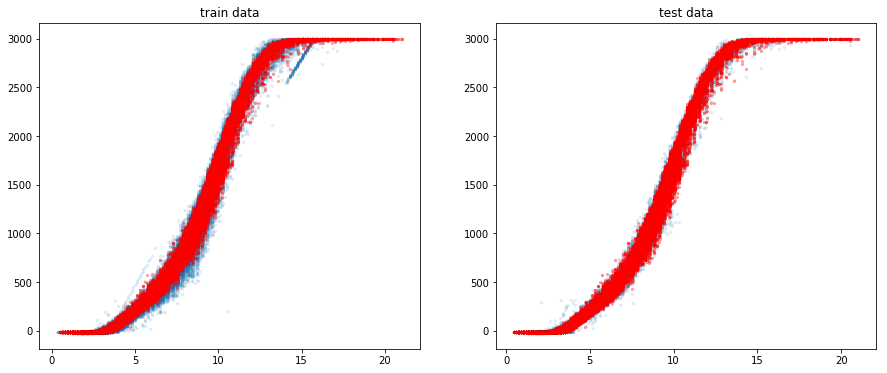

RMSE = 54.8 kW (1.83%)


In [131]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(criterion="mse")
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# plot 
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_rf)

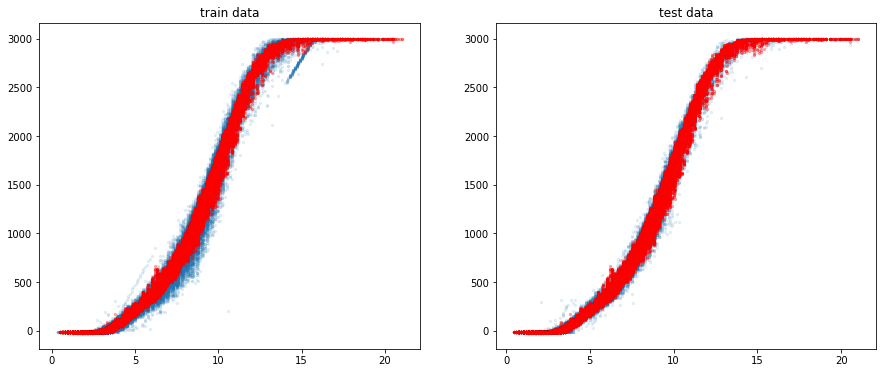

RMSE = 52.4 kW (1.75%)


In [144]:
# Bagged decision Trees

from sklearn import model_selection
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeClassifier

n_sample = 10000
sub_idx = np.random.choice(range(len(y_train)), n_sample, replace=False)
X_train_sub = X_train[sub_idx]
y_train_sub = y_train[sub_idx]


# seed = 7
# kfold = model_selection.KFold(n_splits=10, random_state=seed)
# cart = DecisionTreeClassifier()
# num_trees = 50
cart_bagging = BaggingRegressor(n_estimators=50, n_jobs=-1)
cart_bagging.fit(X_train_sub, y_train_sub)
y_pred_cart = cart_bagging.predict(X_test)

# plot 
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_cart)

In [0]:
# Knn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.mean(axis=0)

# to give more weight to wind speed, we will mutiphy it by 10 (to grid search)
ws_weight = 30
X_train_scaled[:,0] = X_train_scaled[:,0]*ws_weight
X_test_scaled[:,0] = X_test_scaled[:,0]*ws_weight

from sklearn import neighbors

knn = neighbors.KNeighborsRegressor(n_neighbors=20, weights="uniform", n_jobs=-1)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# plot 
plot_pc_train_test(X_train, y_train, X_test, y_test, y_pred_knn)

In [146]:
knn_bagging_grid.get_params()

{'cv': 6,
 'error_score': 'raise-deprecating',
 'estimator': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': -1,
 'estimator__n_neighbors': 5,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'fit_params': None,
 'iid': 'warn',
 'n_jobs': None,
 'param_grid': {'n_neighbors': [5, 10, 15, 20],
  'weights': ['uniform', 'distance']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': 'warn',
 'scoring': None,
 'verbose': 0}